In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Numerical Parameters
N = int(1e2+1)  # Grid Points
T = int(5e2+1)  # Time Steps
L = 10  # Domain Size
snaps = 10 # TODO: Knob
x = np.linspace(0, L, N)  # Spatial Domain
dx = x[2] - x[1]  # Grid Size
dt = 1e-6  # Time Step Size
lmbd = dt / dx
t_tot = dt * T
t = np.linspace(0, t_tot, snaps+1) # Temporal Domain
xx, tt = np.meshgrid(x,t, sparse=False, indexing='xy') # Spatial-Temporal Domain

# Mathematical Parameters
n_0 = 3 / (4 * np.pi)
Gamma_0 = 1 # input("Enter Gamma_0: ")
kappa_0 = 1 # input("Enter kappa_0: ")
beta = 1

# Correlation Parameters
k_fft_norm = 2 * np.pi / (N * dx)
k = k_fft_norm * np.linspace(-N / 2, N / 2 - 1, N)  # Fourier Domain
x3 = np.linspace(-L, 2 * L, 3 * N - 2)  # Correlation Domain

In [2]:
def memoryPDE(u_IC):
    u = np.zeros((2,N))
    u[:] = np.copy(u_IC)
    uL = np.roll(u, 1, axis=1)
    FuL = np.zeros((2,N))
    FuR = np.zeros((2,N))
    u_tot = np.zeros((snaps+1, 2, N))
    u_tot[0] = np.copy(u)
    return uL, u, FuL, FuR, u_tot

def solve_phic(unc, uphic):
    Ac = np.zeros(N)
    # Define b
    bc = 3 - 4 * np.pi * dx * dx * unc
    bc = bc - np.mean(bc)
    # First sweep
    Ac[0] = -0.5
    bc[0] = -0.5 * bc[0]
    for ii in range(1, N):
        Ac[ii] = -1 / (2 + Ac[ii - 1])
        bc[ii] = (bc[ii - 1] - bc[ii]) / (2 + Ac[ii - 1])
    # Second sweep
    uphic[0] = bc[N - 1] - bc[N - 2]
    for ii in range(1, N - 1):
        uphic[ii] = (bc[ii - 1] - uphic[ii - 1]) / Ac[ii - 1]
    return uphic

def memoryODE(un):
    u = np.zeros((2,N))
    for c in range(2):
        u[c] = solve_phic(un[c], u[c])
    uL = np.roll(u, 1, axis=1)
    u_tot = np.zeros((snaps+1, 2, N))
    u_tot[0] = np.copy(u)
    return uL, u, u_tot

In [3]:
# Initial Conditions
disp_freq = 3 * 2 * np.pi / L
n_IC = n_0 * np.ones(N) + .01 * np.sin(disp_freq * x)
v_IC = - .01 #* np.sin(disp_freq * x)
# v_IC = np.zeros(N)
# n_IC = n_0 * np.ones(N) + .01 * (np.random.rand(N)-.5)
# v_IC = .01 * (np.random.rand(N)-.5)

# Memory Allocation
nL, n, FnL, FnR, n_tot = memoryPDE(n_IC)
vL, v, FvL, FvR, v_tot = memoryPDE(v_IC)
phiL, phi, phi_tot = memoryODE(n)
rhs = np.zeros((2,N))

vec = np.stack((n,v))
vecL = np.roll(vec, 1, axis=1)
vec_tot = np.stack((n_tot, v_tot))

In [4]:
# =============== #
# Solve Functions #
# =============== #
def test_flux(unc, uvc): # Inputs - n[c],v[c] / Output - flux_n_c, flux_v_c
    # TODO: Save memory by taking flux_n, flux_v out of function; define static array of fluxes.
    #       Fluxes will depend on current values of n,v which will already update in Solve loop
    flux_unc = np.zeros(N)
    flux_uvc = np.zeros(N)
    for ii in range(N):
        flux_unc[ii] = unc[ii]*uvc[ii]
        flux_uvc[ii] = .5*uvc[ii]*uvc[ii]+np.log(unc[ii])
    godunov_flux = np.stack((flux_unc, flux_uvc))
    return godunov_flux
    

def flux(unc, uvc): # Inputs - n[c],v[c] / Output - flux_n_c, flux_v_c
    # TODO: Save memory by taking flux_n, flux_v out of function; define static array of fluxes.
    #       Fluxes will depend on current values of n,v which will already update in Solve loop
    uvec = np.stack((unc,uvc))
    uvec_L = np.roll(uvec,1)
    flux_unc = np.multiply(unc, uvc)
    flux_uvc = .5*np.multiply(uvc, uvc)+np.log(unc)
    uvec_flux = np.stack((flux_unc, flux_uvc))
    uvec_flux_L = np.roll(uvec_flux, 1)
    
    godunov_flux = np.zeros((2,N))
    for eq in range(2): # Iterate over system
        for ii in range(N): # Iterate over spacial values
            if uvec_L[eq,ii] > uvec[eq,ii]:
                godunov_flux[eq,ii] = np.maximum(uvec_flux_L[eq,ii], uvec_flux[eq,ii])
            elif uvec_L[eq,ii] < uvec[eq,ii]:
                godunov_flux[eq][ii] = np.minimum(uvec_flux_L[eq][ii], uvec_flux[eq][ii])
            else:
                godunov_flux[eq][ii] = 0.0    

    godunov_flux = uvec_flux
    return godunov_flux

def sys_to_vec(unc, uvc):
    uveccR = np.stack((nc,vc))
    uveccL = np.roll(vec, 1, axis=1)
    return uveccL, uveccR
    
def vec_to_sys(uvecc):
    unRc = np.copy(vec[0,c])
    unLc = np.roll(unRc,1)
    uvRc = np.copy(vec[1,c])
    uvLc = np.roll(uvRc,1)
    return unLc, unRc, uvLc, uvRc

In [5]:
# ===== #
# Solve #
# ===== #
for c in range(2): # Iterate through correlations
    cur_snap = 0
    for tt in range(1,T): # Iterate Time
        
        sys_Flux = flux(n[c], v[c])      
        Fn = sys_Flux[0]
        Fv = sys_Flux[1] 

        if tt % 50 == 0 and c == 0:
            print(tt)
            print("n", '%s' % float('%.3g' % n[c,-1]), '%s' % float('%.3g' % n[c,0]), '%s' % float('%.3g' % n[c,1]),
                  '%s' % float('%.3g' % n[c,2]), '%s' % float('%.3g' % n[c,3]), '%s' % float('%.3g' % n[c,4]),
                  '%s' % float('%.3g' % n[c,5]), '%s' % float('%.3g' % n[c,6]), '%s' % float('%.3g' % n[c,7]),
                  '%s' % float('%.3g' % n[c,8]), '%s' % float('%.3g' % n[c,9]), '%s' % float('%.3g' % n[c,10]))
#             print("v", '%s' % float('%.3g' % v[c,-1]), '%s' % float('%.3g' % v[c,0]), '%s' % float('%.3g' % v[c,1]),
#                   '%s' % float('%.3g' % v[c,2]), '%s' % float('%.3g' % v[c,3]), '%s' % float('%.3g' % v[c,4]),
#                   '%s' % float('%.3g' % v[c,5]), '%s' % float('%.3g' % v[c,6]), '%s' % float('%.3g' % n[c,7]),
#                   '%s' % float('%.3g' % n[c,8]), '%s' % float('%.3g' % n[c,9]), '%s' % float('%.3g' % v[c,10]))
            print("Fn", '%s' % float('%.3g' % Fn[-1]), '%s' % float('%.3g' % Fn[0]), '%s' % float('%.3g' % Fn[1]),
                  '%s' % float('%.3g' % Fn[2]), '%s' % float('%.3g' % Fn[3]), '%s' % float('%.3g' % Fn[4]),
                  '%s' % float('%.3g' % Fn[5]), '%s' % float('%.3g' % Fn[6]), '%s' % float('%.3g' % Fn[7]),
                  '%s' % float('%.3g' % Fn[8]), '%s' % float('%.3g' % Fn[9]), '%s' % float('%.3g' % Fn[10]))
#             print("n*v", '%s' % float('%.3g' % (n[c,-1]*v[c,-1])), '%s' % float('%.3g' % (n[c,0]*v[c,0])), '%s' % float('%.3g' % (n[c,1]*v[c,1])))

#         n[c,0] = n[c,N-1]
#         v[c,0] = v[c,N-1]
#         for ii in range(1,N):
#             n[c,ii] = n[c,ii]-lmbd*Fn[ii]
#             v[c,ii] = v[c,ii]-lmbd*Fv[ii]

        rhs[c] = -Gamma_0*(phi[c] - np.roll(phi[c],1))/dx
        
        n[c,0] = n[c,N-1]
        v[c,0] = v[c,N-1]
        for ii in range(0,N):
            n[c,ii] = n[c,ii]-lmbd*(Fn[ii]-Fn[ii-1])
            v[c,ii] = v[c,ii]-lmbd*(Fv[ii]-Fv[ii-1])+rhs[c,ii]

        phi[c] = solve_phic(n[c],phi[c])
        
        #  Snapshot
        if tt % ((T-1)/snaps) == 0:
            cur_snap += 1
            n_tot[cur_snap,c] = n[c]
            v_tot[cur_snap,c] = v[c]
            phi_tot[cur_snap,c] = phi[c]

50
n 0.257 0.256 0.223 0.243 0.244 0.246 0.247 0.248 0.248 0.249 0.249 0.248
Fn -71.0 -69.9 1.46 -0.0695 -0.0153 0.0647 0.168 0.291 0.429 0.577 0.729 0.878
100
n 0.299 0.298 0.179 0.245 0.244 0.246 0.247 0.248 0.248 0.249 0.249 0.248
Fn -82.5 -83.5 5.43 -0.631 -0.533 -0.379 -0.179 0.062 0.334 0.625 0.925 1.22
150
n 0.317 0.317 0.156 0.248 0.244 0.245 0.247 0.248 0.248 0.248 0.248 0.248
Fn 23.8 21.3 5.74 -1.76 -1.61 -1.39 -1.1 -0.751 -0.355 0.0723 0.513 0.949
200
n 0.28 0.281 0.186 0.253 0.244 0.245 0.246 0.247 0.248 0.248 0.248 0.248
Fn 92.4 92.4 9.42 -2.81 -2.52 -2.24 -1.86 -1.41 -0.887 -0.326 0.253 0.826
250
n 0.24 0.24 0.218 0.261 0.244 0.245 0.246 0.247 0.248 0.248 0.248 0.247
Fn 45.7 47.2 15.6 -3.21 -2.78 -2.43 -1.95 -1.38 -0.732 -0.0353 0.683 1.39
300
n 0.233 0.233 0.215 0.27 0.243 0.245 0.246 0.247 0.247 0.247 0.247 0.247
Fn -33.8 -32.2 15.6 -3.31 -2.67 -2.23 -1.66 -0.973 -0.199 0.632 1.49 2.33
350
n 0.264 0.263 0.173 0.28 0.243 0.245 0.246 0.246 0.247 0.247 0.247 0.246
Fn -95.9

In [6]:
# ============== #
# Plot Functions #
# ============== #
def plot(ux, u_tot):
    for c in range(2):
        fig = plt.figure(figsize=(15,15))
        plt.title("Plot")    
        for asnap in range(snaps+1):
            plt.plot(ux, u_tot[asnap,c], label=str(asnap/snaps))
        plt.legend()
    plt.show(block=False)

def cmap(ux, ut, u_tot): 
    for c in range(2):
        fig = plt.figure(figsize=(15,15))
        color_map = plt.contourf(ux, ut, u_tot[:,c])
        plt.colorbar()
        plt.ylabel("Time")
        plt.xlabel("Space")
        plt.show(block=False)    

def calculate_2dft(u_tot):
    fft = np.fft.ifftshift(u_tot-np.mean(u_tot[:,:]))
    fft = np.fft.fft2(fft)
    return np.abs(np.fft.fftshift(fft))

def disp_rel_cmap(ux, ut, u_tot):
    fft = calculate_2dft(u_tot)
    cmap(ux, ut, fft)
    
# def subplot(u_tot):
#     fig, axes = plt.subplots(nrows=3, ncols=3)
#     # find minimum of minima & maximum of maxima
#     minmin = np.min(for c in range(2): u_tot[:,c])
#     maxmax = np.max(for c in range(2): u_tot[:,c])
#     images = []
#     for ii in range(3):
#         for jj in range(3):
#             im = axes[ii][jj].imshow(u_tot[ii+jj], vmin=minmin, vmax=maxmax,
#                                      extent=(0,L,0,t), aspect='auto', cmap='viridis')
#             axes[ii][jj].set_title('Γ = ' + str(Gamma[ii]) + ', κ = ' + str(kappa[jj]))
#             axes[ii][jj].set_ylabel("Time")
#             axes[ii][jj].set_xlabel("Space")
#             images.append(im)

#     fig.tight_layout(pad = .01)
#     fig.subplots_adjust(top=0.9)
#     fig.suptitle("Density: No Correlations")
#     cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=1)
#     plt.show(block=False)
    
def plot3D():
    fig = plt.figure()
    

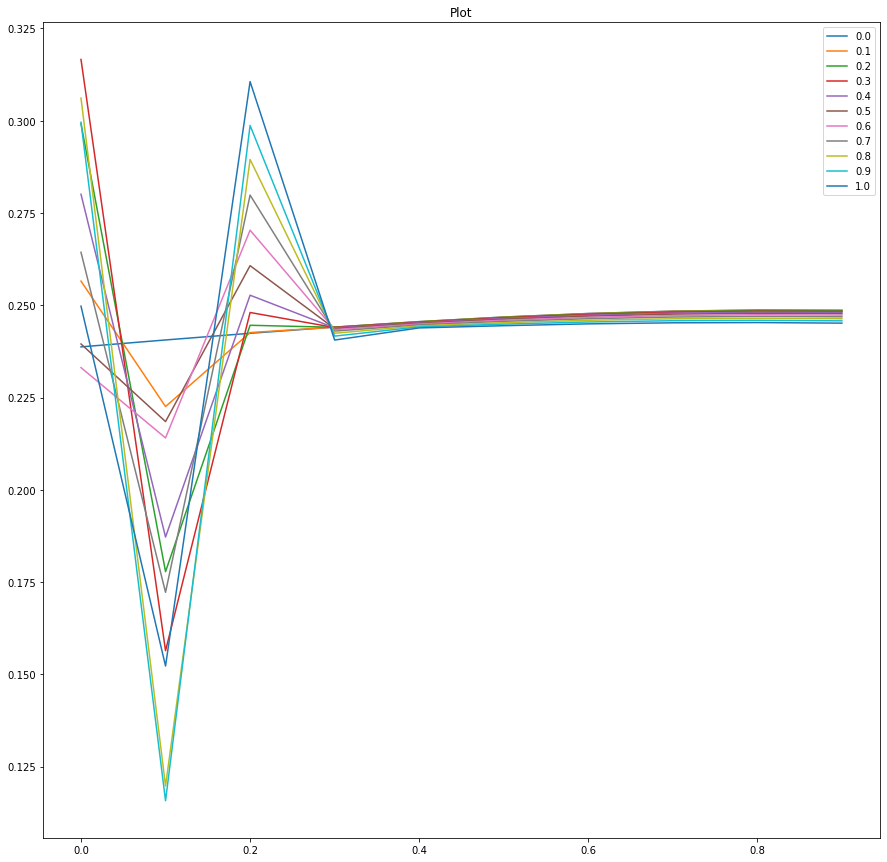

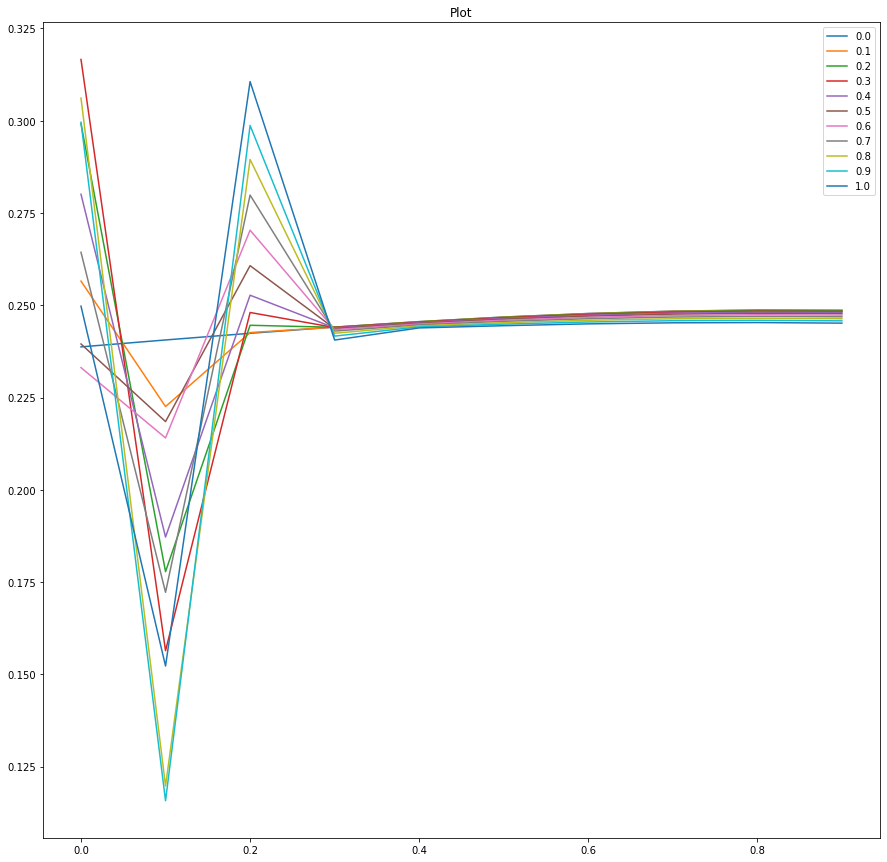

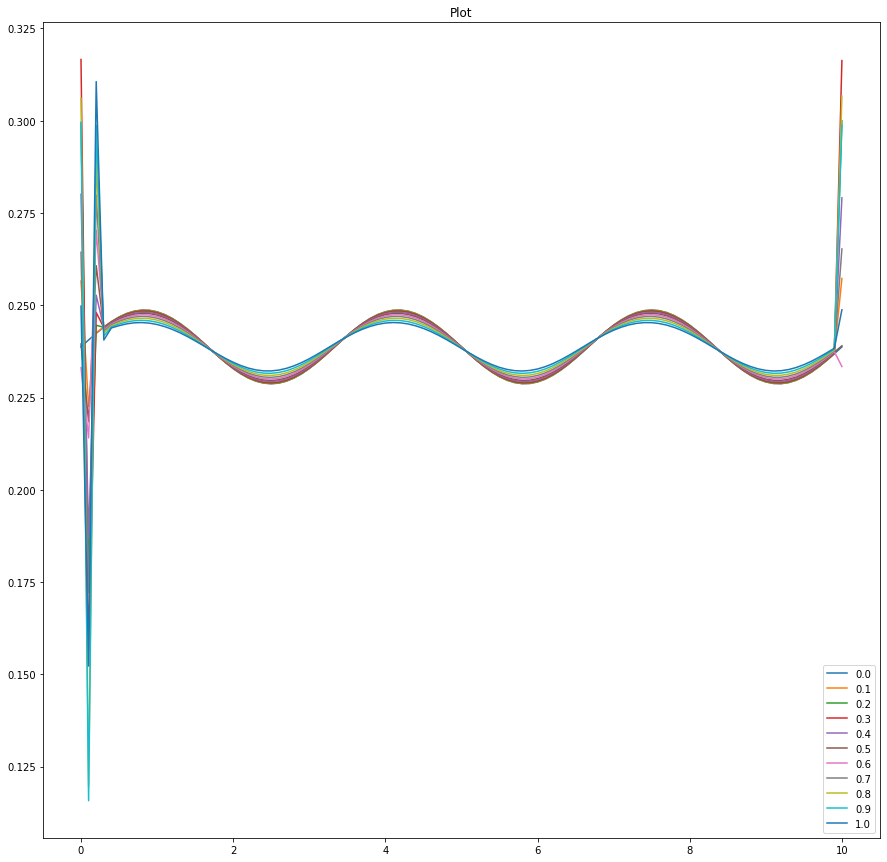

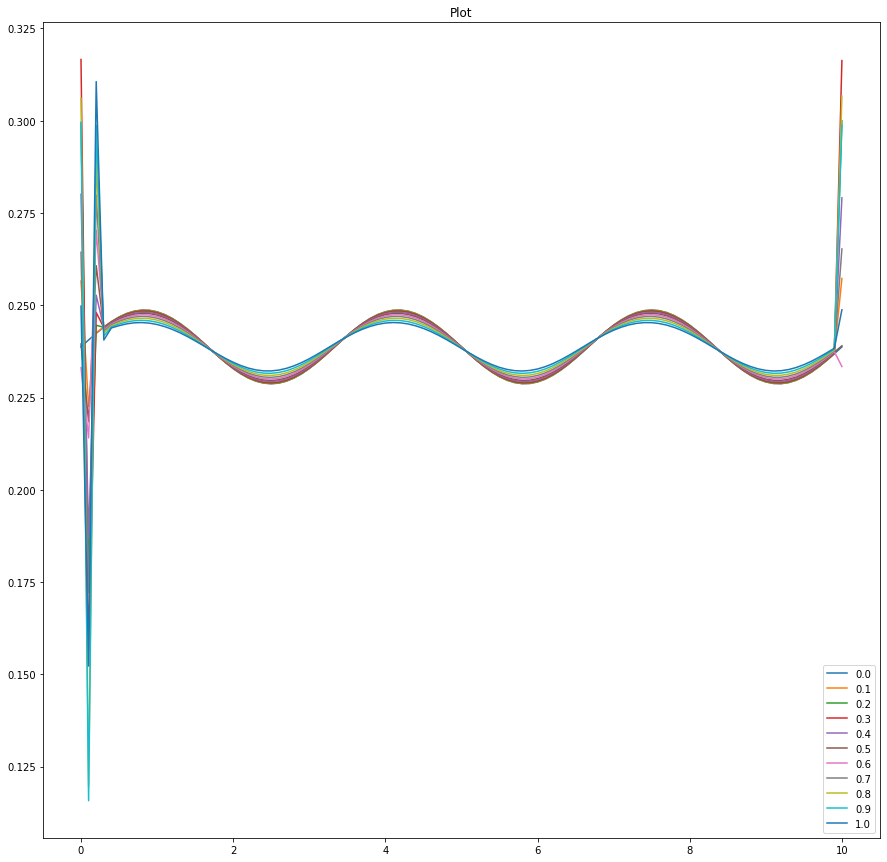

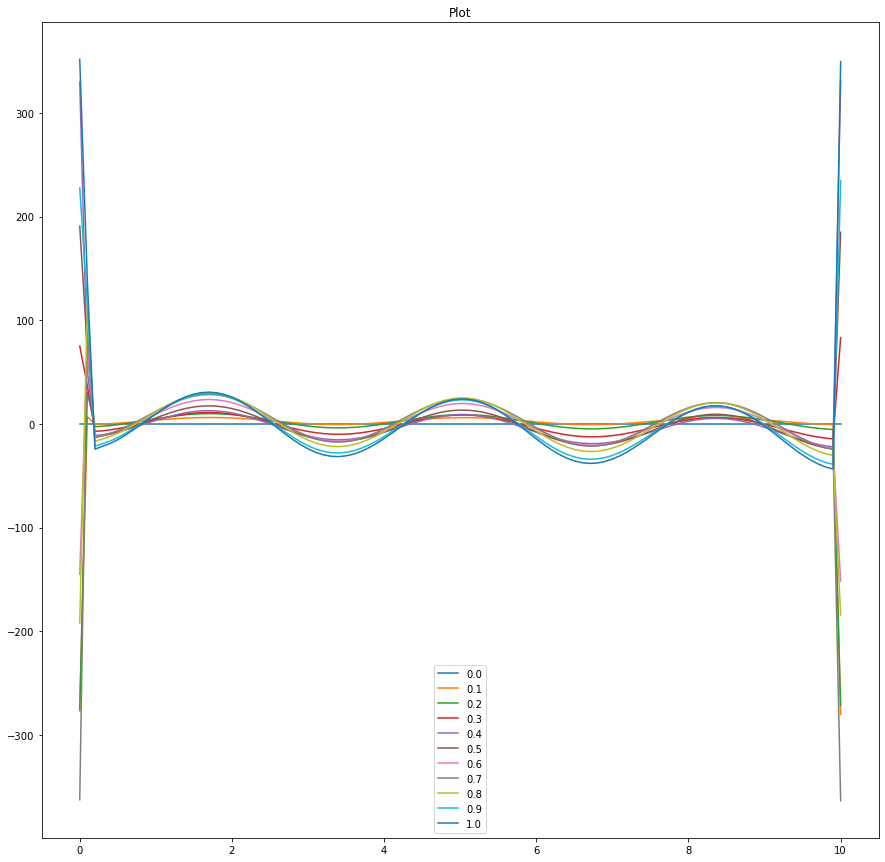

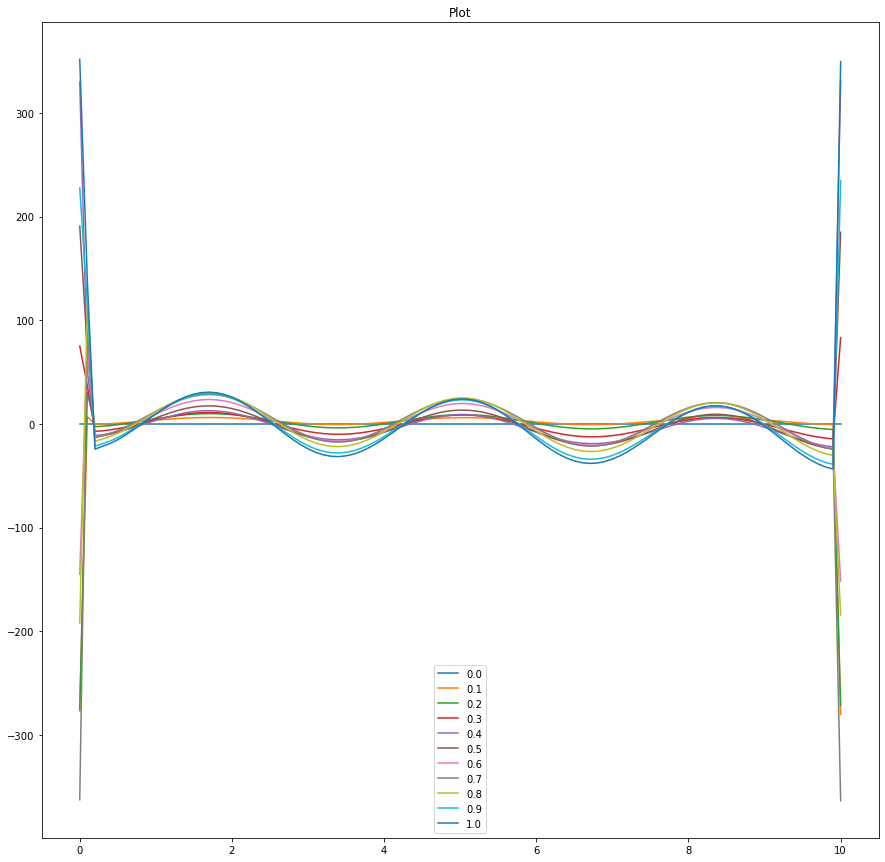

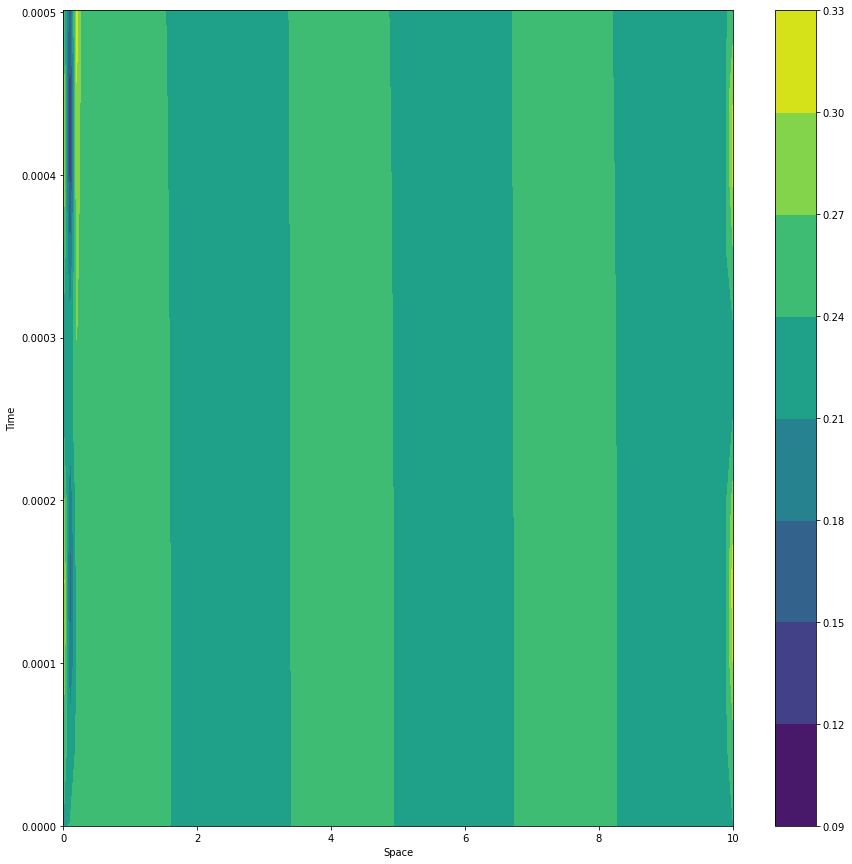

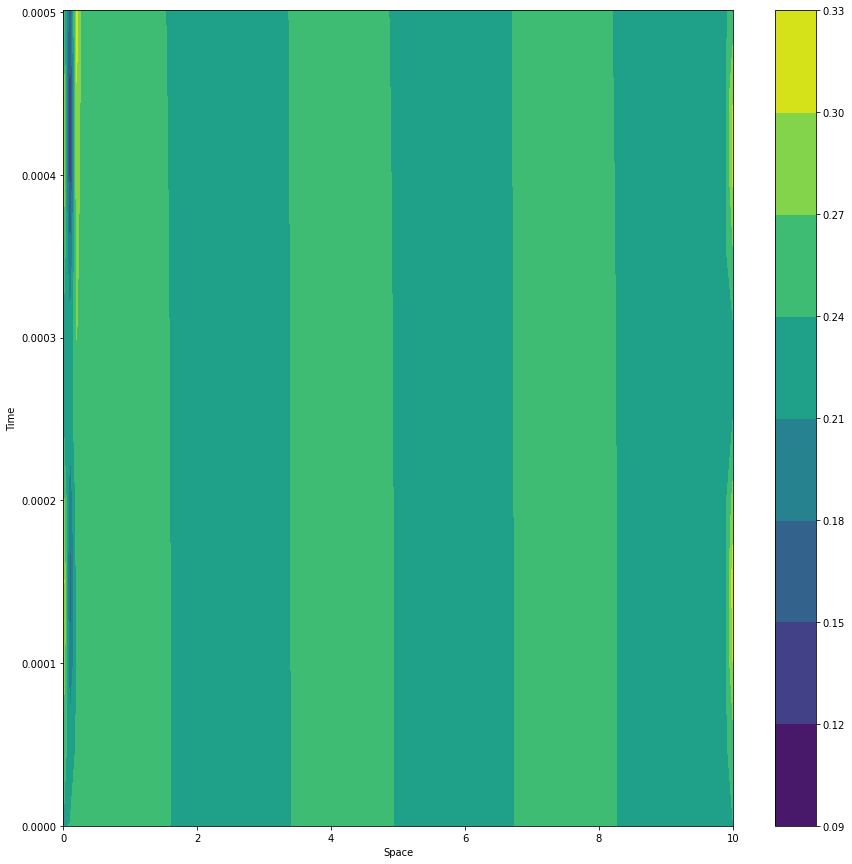

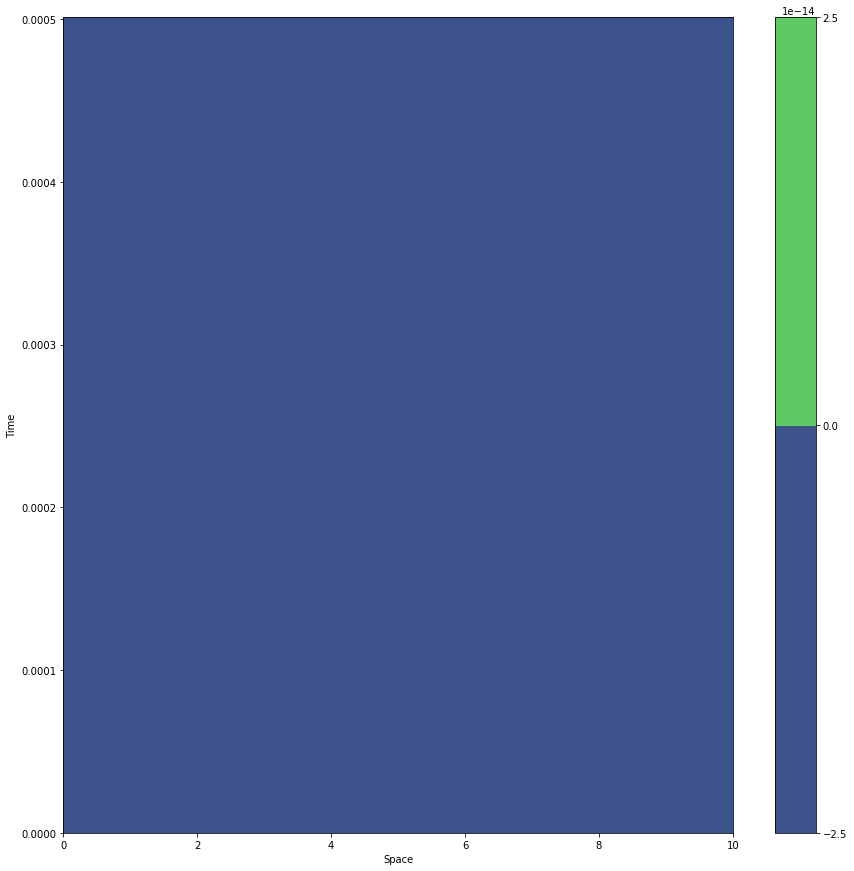

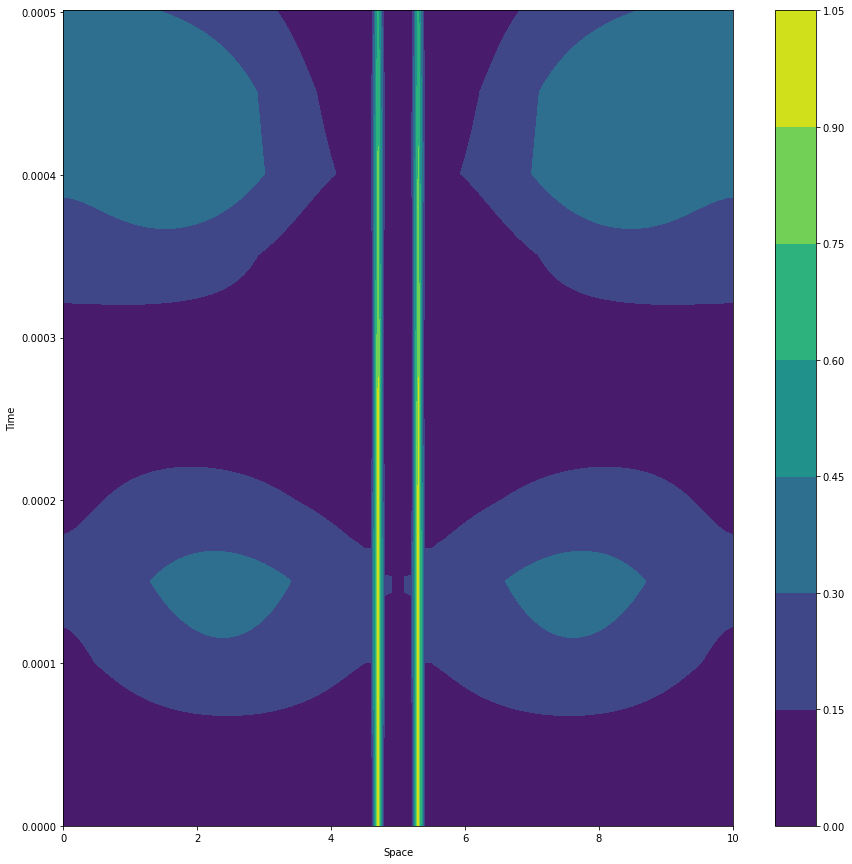

In [7]:
# ==== #
# Plot #
# ==== #
n_tot_rev = np.flip(n_tot,0)
v_tot_rev = np.flip(v_tot,0)

plot(x[0:10],n_tot[:,:,0:10])
plot(x,n_tot)
plot(x,v_tot)
cmap(x, t, n_tot) # TODO: no rev?? check orientation of colormap wrt time axis
disp_rel_cmap(x, t, n_tot)

# plot(x,v_tot_rev)
# cmap(x, t, v_tot_rev)
# disp_rel_cmap(x, t, v_tot_rev)